# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection as cross_validation
import warnings
warnings.filterwarnings("ignore")

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 30000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (30000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(28072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.57333333333332

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(28072, 10)


1    23606
0     4466
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3).
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save option.  the case contained 15(FIFTEEN, FULL SIZED BAGS) 

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I have canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use Yes NuNaturals uses GMO products SO I have canceled my subscribe and save order and am now using a href http www amazon com gp product B001ELL3U0 Stevita Stevia Clear Liquid Extract 3 3 Ounce Container Pack of 3 a 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 28072/28072 [00:11<00:00, 2405.64it/s]


In [23]:
preprocessed_reviews[1500]

'favorite stevia product subscribe save queried customer service nunaturals gmo use yes nunaturals uses gmo products canceled subscribe save order using'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
len(preprocessed_reviews)

28072

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:

labels = final.head(100000)['Score']
# split the train data set into cross validation train and cross validation test

X_1_bow, X_test_bow, y_1_bow, y_test_bow = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_bow, X_cv_bow, y_tr_bow, y_cv_bow = cross_validation.train_test_split(X_1_bow, y_1_bow, test_size=0.3)
count_vect = CountVectorizer(min_df=10) #in scikit-learn

X_tr_bow = count_vect.fit_transform(X_tr_bow)
X_cv_bow = count_vect.transform(X_cv_bow)
X_test_bow =count_vect.transform(X_test_bow)
X_1_bow = count_vect.transform(X_1_bow)
print("some feature names ", count_vect.get_feature_names()[:10])


some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'accepted']


In [26]:
labels.value_counts()

1    23606
0     4466
Name: Score, dtype: int64

<h3>Balancing the Dataset<h3>

In [27]:
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

sm = RandomUnderSampler(random_state=42)
X_res, y_res = sm.fit_resample(X_tr_bow,y_tr_bow)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 958, 1: 958})


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (11496, 6838)
the number of unique words including both unigrams and bigrams  6838


## [4.3] TF-IDF

In [29]:
# split the train data set into cross validation train and cross validation test

X_1_tfidv, X_test_tfidv, y_1_tfidv, y_test_tfidv = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_tfidv, X_cv_tfidv, y_tr_tfidv, y_cv_tfidv = cross_validation.train_test_split(X_1_tfidv, y_1_tfidv, test_size=0.3)
tf_idf_vect = TfidfVectorizer( min_df=10)

X_tr_tfidv = tf_idf_vect.fit_transform(X_tr_tfidv)
X_cv_tfidv = tf_idf_vect.transform(X_cv_tfidv)
X_test_tfidv =tf_idf_vect.transform(X_test_tfidv)
X_1_tfidv = tf_idf_vect.transform(X_1_tfidv)


print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])


some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'acids', 'acquired', 'across']


## [4.4] Word2Vec

In [30]:
# Train your own Word2Vec model using your own text corpus
X_1_w2v, X_test_w2v, y_1_w2v, y_test_w2v = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_w2v, X_cv_w2v, y_tr_w2v, y_cv_w2v = cross_validation.train_test_split(X_1_w2v, y_1_w2v, test_size=0.3)

i=0
list_of_sentance=[]
for sentance in X_tr_w2v:
    list_of_sentance.append(sentance.split())

In [31]:
# Using Google News Word2Vectors

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 8 times
    w2v_model=Word2Vec(list_of_sentance,min_count=8,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8266193866729736), ('fantastic', 0.780784547328949), ('awesome', 0.7706314325332642), ('terrific', 0.7662637233734131), ('wonderful', 0.7587263584136963), ('excellent', 0.7541371583938599), ('amazing', 0.7114664912223816), ('perfect', 0.7096889019012451), ('fabulous', 0.7023261785507202), ('incredible', 0.6915047764778137)]
[('coolest', 0.7102765440940857), ('best', 0.7075901627540588), ('nastiest', 0.6946667432785034), ('disgusting', 0.684651255607605), ('experienced', 0.6760872602462769), ('greatest', 0.6684876680374146), ('tastiest', 0.6308022141456604), ('worse', 0.6221916079521179), ('terrible', 0.6164180040359497), ('closest', 0.6079938411712646)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 8 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 8 times  10435
sample words  ['everything', 'great', 'second', 'time', 'bought', 'continue', 'thanks', 'large', 'boxes', 'cereal', 'price', 'husband', 'eating', 'box', 'per', 'loving', 'taste', 'lasting', 'effect', 'lunch', 'happy', 'deal', 'could', 'find', 'local', 'supermarkets', 'months', 'ago', 'nowhere', 'found', 'every', 'kellogg', 'makes', 'quit', 'making', 'soon', 'case', 'right', 'best', 'stuff', 'planet', 'trader', 'joe', 'everyday', 'spice', 'quick', 'easy', 'season', 'foods', 'sooo']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

 10%|▉         | 4857/49000 [00:10<01:31, 485.05it/s]

KeyboardInterrupt: 

 10%|▉         | 4857/49000 [00:20<03:02, 242.41it/s]

In [ ]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_test_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

In [35]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_cv_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 21000/21000 [00:41<00:00, 509.32it/s]

21000
50


In [36]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_1_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_1.append(sent_vec)
print(len(sent_vectors_1))
print(len(sent_vectors_1[0]))

100%|██████████| 70000/70000 [02:12<00:00, 527.27it/s]

70000
50


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()

tf_idf_matrix = model.fit_transform(X_tr_w2v)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

In [38]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_1_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_1.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [30:01<00:00, 38.85it/s]


In [39]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_test_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [12:42<00:00, 39.35it/s]


In [40]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_cv_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 21000/21000 [08:52<00:00, 39.43it/s]


In [41]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_tr_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 49000/49000 [20:51<00:00, 39.16it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [37]:
from sklearn.linear_model import LogisticRegression

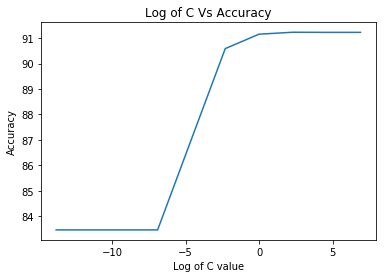

Best value of C is : 10.000000


In [44]:


from sklearn.metrics import accuracy_score
ch = .0000001
x = []
y = []
for i in range(1,11):
    # instantiate learning model (C  = 0.000001)
    clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = ch *10,multi_class="auto",tol=.01)
    ch = ch * 10
    # fitting the model on crossvalidation train
    clf.fit(X_tr_bow, y_tr_bow)
    # predict the response on the crossvalidation train
    pred = clf.predict(X_cv_bow)
    # evaluate CV accuracy
    acc = accuracy_score(y_cv_bow, pred, normalize=True) * int(100)
  
    x.append(np.log(ch))
    y.append(acc)

plt.xlabel('Log of C value')
plt.ylabel('Accuracy')

plt.title("Log of C Vs Accuracy")
best = y.index(max(y))

plt.plot(x,y)
plt.show()

print("Best value of C is : %f"% (np.exp(x[best])))

In [45]:
clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = 10 ,multi_class="auto",tol=.01)

clf.fit(X_1_bow, y_1_bow)
   
pred = clf.predict(X_test_bow)
   
acc = accuracy_score(y_test_bow, pred, normalize=True) * int(100)

acc

91.47333333333333

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [ ]:
coef_l1_LR = clf.coef_.ravel()

sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100

print("Sparsity with L1 Regularisation : ", sparsity_l1_LR)


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [27]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
from sklearn.metrics import accuracy_score
ch = .0000001
x = []
y = []
for i in range(1,15):
    # instantiate learning model (k = 30)
    clf = LogisticRegression(penalty = 'l2',random_state=0, solver='saga', C = ch *10,multi_class="auto",tol = .01)
    ch = ch * 10
    # fitting the model on crossvalidation train
    clf.fit(X_tr_bow, y_tr_bow)
    # predict the response on the crossvalidation train
    pred = clf.predict(X_cv_bow)
    # evaluate CV accuracy
    acc = accuracy_score(y_cv_bow, pred, normalize=True) * int(100)
    #print('\nCV accuracy for alpha = %d is %d%%' % (al*10, acc))
    x.append(np.log(ch*10))
    y.append(acc)

plt.xlabel('Log of C value')
plt.ylabel('Accuracy')

plt.title("Log of C Vs Accuracy")
best = y.index(max(y))

plt.plot(x,y)
plt.show()

print("Best value of C is : %f"% (np.exp(x[best])))

In [32]:
clf = LogisticRegression(penalty = 'l2',random_state=0, solver='saga', C = 10 ,multi_class="auto",tol=.01)

clf.fit(X_1_bow, y_1_bow)
   
pred = clf.predict(X_test_bow)
   
acc = accuracy_score(y_test_bow, pred, normalize=True) * int(100)

acc

90.17106407654393

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [ ]:
Get the weights W after fit your model with the data X i.e Train data.
Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
Fit the model again on data X' and get the weights W'
Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
Now find the % change between W and W' (| (W-W') / (W) |)*100)
Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector
Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5
Print the feature names whose % change is more than a threshold x(in our example it's 2.5)

In [59]:
X1_tr_bow = X_tr_bow[:]

In [29]:
clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = 10 ,multi_class="auto",tol=.01)

clf.fit(X_tr_bow, y_tr_bow)

W = clf.coef_
#print(X1_tr_bow)

In [60]:
X1_tr_bow.data = X1_tr_bow.data +1

In [80]:
X1_tr_bow

<5632x2480 sparse matrix of type '<class 'numpy.float64'>'
	with 152754 stored elements in Compressed Sparse Row format>

In [52]:
X_tr_bow

<5632x2480 sparse matrix of type '<class 'numpy.int64'>'
	with 152754 stored elements in Compressed Sparse Row format>

In [61]:


clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = 10 ,multi_class="auto",tol=.01)

clf.fit(X1_tr_bow, y_tr_bow)
W1 = clf.coef_


In [62]:
W+=.000001
W1+=.000001


In [63]:
Diff = W- W1

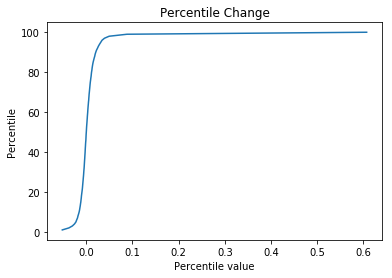

In [64]:
x = []
y = []
for i in range(1,101):

    x.append(np.percentile(Diff ,i))
    y.append(i)

plt.xlabel('Percentile value')
plt.ylabel('Percentile')

plt.title("Percentile Change")


plt.plot(x,y)
plt.show()


In [65]:
m = []

print(len(x))
for i in range(1,99):
    
    m.append(x[i+1]-x[i])
    
print(m)

100
[0.007618670438006965, 0.004541982001234547, 0.00304822612957897, 0.0015900265770660317, 0.0018317697799558746, 0.0010066646243938916, 0.00133646088445942, 0.0011951291505370148, 0.0009156865472790803, 0.0006914809648239217, 0.0007238134452223991, 0.0006045398573689773, 0.0006647787592807021, 0.00047426337388249175, 0.0005136838389561572, 0.0003884926721437233, 0.0005354542477156304, 0.0005696173961324547, 0.0005402154482760275, 0.0004938551897538581, 0.00035572923787574075, 0.00038391015423713815, 0.0003762902902153236, 0.0004011902257607756, 0.00034251400930114355, 0.0004204501379576307, 0.0003288808783989735, 0.0002886902078818058, 0.00033671555489367747, 0.0003920182864248301, 0.00028642860598110213, 0.00024168865623825416, 0.0002686768388733395, 0.0002697066079383396, 0.0003133346140418384, 0.00022921796765355352, 0.00030100130562296483, 0.0002650001895515555, 0.00020921400666848314, 0.00022765494130216803, 0.00029440033298563017, 0.00021670144878119246, 0.00030273707487619224

In [66]:
for i in range(0,10):
    print(np.log(np.percentile(Diff ,99+(i+1)*.1)-np.percentile(Diff ,99+(i*.1))))

-5.2822847031491795
-4.985424026569263
-4.937258995727363
-4.539720101509547
-4.391880123753358
-4.616078481777165
-4.1377092423090875
-3.1896941616846446
-3.234756391938389
-0.9942175392431808


In [48]:
for i in Diff[0]:
    if i >=int(np.percentile(Diff ,99.9)):
        print(Diff[0].tolist().index(i))
        


0
1
2
3
4
7
8
9
12
13
14
19
21
23
24
25
27
28
31
33
34
35
41
42
43
44
45
51
52
53
55
58
60
61
62
63
64
66
67
68
71
74
75
77
78
79
81
85
86
87
88
94
97
98
100
101
104
105
108
109
110
111
112
115
117
118
120
124
125
126
128
129
130
131
132
133
137
138
139
140
141
142
144
145
146
147
150
151
153
154
155
157
158
160
162
163
164
165
166
167
169
170
171
176
177
179
181
182
185
188
191
192
193
196
197
198
202
203
204
205
210
211
212
213
214
215
216
218
219
220
224
226
231
233
239
240
243
245
246
249
250
251
253
255
257
259
261
262
263
266
271
272
276
277
279
282
283
288
289
290
291
292
299
300
301
302
305
308
311
314
315
316
317
319
321
322
323
324
326
327
329
330
333
335
337
338
339
340
341
342
347
348
349
351
352
353
354
356
363
366
367
368
369
370
375
376
378
380
381
382
383
384
385
386
387
389
390
391
393
394
397
398
401
404
409
410
411
413
415
416
417
418
420
422
424
425
426
430
431
435
437
438
439
444
445
446
449
451
452
453
454
457
458
459
460
461
462
463
467
469
470
471
472
475
477
48

3242
3245
3247
3248
3250
3252
3253
3257
3259
3264
3266
3267
3269
3271
3275
3276
3277
3280
3281
3283
3285
3286
3287
3288
3289
3293
3295
3296
3297
3298
3299
3300
3301
3303
3304
3305
3306
3307
3308
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3324
3328
3329
3330
3331
3332
3336
3338
3340
3341
3342
3343
3344
3345
3346
3347
3349
3350
3352
3359
3360
3362
3365
3366
3370
3372
3374
3376
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3390
3393
3394
3395
3396
3397
3398
3401
3402
3403
3404
3407
3408
3410
3412
3413
3414
3417
3419
3420
3423
3426
3428
3429
3430
3431
3432
3434
3435
3438
3439
3440
3441
3442
3447
3449
3451
3452
3453
3454
3455
3456
3457
3458
3464
3469
3471
3474
3476
3477
3481
3482
3486
3487
3488
3490
3491
3492
3494
3495
3496
3498
3499
3500
3501
3503
3504
3505
3506
3508
3509
3510
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3528
3529
3531
3533
3535
3536
3538
3539
3540
3541
3543
3546
3547
557
3550
3551
3553
3556
3557
3558
3560
3562
3566
3567
3568
3

In [119]:
W[0][2]

0.07393102139149368

In [127]:
count_vect.inverse_transform(W[0][2345])

[array(['ability'], dtype='<U23')]

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [ ]:
pos_class_prob_sorted  = clf.coef_[0,:].argsort()
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[-10:]))

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>


In [ ]:
neg_class_prob_sorted =clf.coef_[0, :].argsort()
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[-10:]))